In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv
import shutil

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NOTE! Installing ujson may make loading annotations faster.


2024-07-15 12:33:02.220 | DEBUG    | incision_detection_mmdet:<module>:19 - 1.12.0a0+8a1a93a
2024-07-15 12:33:02.222 | DEBUG    | incision_detection_mmdet:<module>:24 - mmdet.version=2.25.0
2024-07-15 12:33:02.222 | DEBUG    | incision_detection_mmdet:<module>:29 - 11.7
2024-07-15 12:33:02.223 | DEBUG    | incision_detection_mmdet:<module>:30 - GCC 9.4
2024-07-15 12:33:02.692 | DEBUG    | pigleg_cv:<module>:60 - DEVICE=cuda:0


In [2]:
!pwd

/webapps/piglegsurgery/piglegcv


In [3]:
import torch

torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Mon Jul 15 12:33:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:0B:00.0 Off |                  N/A |
|  0%   60C    P8             17W /  165W |      18MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
torch.__version__

'1.12.0a0+8a1a93a'

In [6]:
Path("~/.cache/torch/hub/checkpoints/").expanduser().exists()

False

In [7]:
!ls ~/.cache/torch/hub/checkpoints/

ls: cannot access '/home/appuser/.cache/torch/hub/checkpoints/': No such file or directory


In [8]:
# pip install mmcv-full

In [9]:
import logging
import mmcv

# logger = logging.getLogger(name='torch')
# logger.setLevel(logging.WARNING)

# print(logging.root.manager.loggerDict)

# loggers = [logging.getLogger(name=name).setLevel(logging.WARNING) for name in logging.root.manager.loggerDict]
# loggers



In [10]:
loggers = [logging.getLogger(name=name) for name in logging.root.manager.loggerDict]

In [11]:
loggers

[<Logger concurrent.futures (WARNING)>,
 <Logger concurrent (WARNING)>,
 <Logger asyncio (WARNING)>,
 <Logger tornado.access (WARNING)>,
 <Logger tornado (WARNING)>,
 <Logger tornado.application (WARNING)>,
 <Logger tornado.general (WARNING)>,
 <Logger prompt_toolkit.buffer (WARNING)>,
 <Logger prompt_toolkit (WARNING)>,
 <Logger parso.python.diff (WARNING)>,
 <Logger parso.python (WARNING)>,
 <Logger parso (WARNING)>,
 <Logger parso.cache (WARNING)>,
 <Logger pkg_resources.extern.packaging.tags (WARNING)>,
 <Logger pkg_resources.extern.packaging (WARNING)>,
 <Logger pkg_resources.extern (WARNING)>,
 <Logger pkg_resources (WARNING)>,
 <Logger IPKernelApp (DEBUG)>,
 <Logger urllib3.util.retry (WARNING)>,
 <Logger urllib3.util (WARNING)>,
 <Logger urllib3 (WARNING)>,
 <Logger urllib3.connection (WARNING)>,
 <Logger urllib3.response (WARNING)>,
 <Logger urllib3.connectionpool (WARNING)>,
 <Logger urllib3.poolmanager (WARNING)>,
 <Logger charset_normalizer (WARNING)>,
 <Logger socks (WARNI

In [12]:
from loguru import logger

# Run whole video processing

In [42]:
is_microsurgery = False
test_first_seconds = False
use_application_outputdir = False
use_application_outputdir = True
force_tracker = False

patch = "*/Anasto*.mp4"
# patch = "*/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov"
patch = "Einzel.MOV"
patch = "test_4.mp4"; n_stitches=0
patch = "2021_11_03_A_Tengler"
patch = "Bad-2021_11_03_A_Noll_Alexander_Einz"
# patch = "Sascha.mp4"; n_stitches=5
# patch = "micro_01*.mp4"
# patch = "2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"; n_stitches=5
# patch = "Katharina_Einzelknopfnaht"; n_stitches=3
# patch = "Johanna"
# n_stitches = 2

img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(f"*/*{patch}*"))
mediafile_path = img_pths[0]


# original outputdir
if use_application_outputdir:
    outputdir = list(list(Path("../piglegsurgeryweb/media/").glob(f"*/*{patch}*.zip"))[0].parent.glob("*/meta.json"))[0].parent
    outputdir = outputdir.absolute().resolve()
    outputdir
else:
    outputdir = Path("./del_test_video_output/") / mediafile_path.name

In [43]:
mediafile_path

PosixPath('../piglegsurgeryweb/media/upload/20220707-190833_Bad-2021_11_03_A_Noll_Alexander_Einzelknopfnaht_3524f5f524354e24447f1d5a96f8643e4ec47159/Bad-2021_11_03_A_Noll_Alexander_Einzelknopfnaht.preview.jpg')

In [44]:
# list(zf.parent.glob("*"))
import json

stitch_json_fn = outputdir / "stitch_detection_0.json"
with open(stitch_json_fn, "r") as f:
    stitch_json = json.load(f)

meta_json_fn = outputdir / "meta.json"
with open(meta_json_fn, "r") as f:
    meta_json = json.load(f)

In [45]:
bbox_incision = meta_json["incision_bboxes"][0]
bboxes_stitches = stitch_json["stitch_bboxes"]

def make_stitch_bboxes_global(bbox_incision, bboxes_stitches):
    
    return [
        [
            bbox_incision[0] + bbox_stitch[0],
            bbox_incision[1] + bbox_stitch[1],
            bbox_incision[0] + bbox_stitch[2],
            bbox_incision[1] + bbox_stitch[3]
        ]
        for bbox_stitch in bboxes_stitches
    ]

bboxes_stitches_global = make_stitch_bboxes_global(bbox_incision, bboxes_stitches)
bboxes_stitches_global

[[284.0910339355469,
  242.48029804229736,
  292.8063430786133,
  265.39517974853516],
 [312.77503204345703, 241.43531322479248, 322.9688720703125, 264.447265625],
 [253.55134201049805,
  240.8446559906006,
  263.78392028808594,
  261.4162712097168],
 [221.3450756072998,
  241.95167446136475,
  229.2840175628662,
  259.69200134277344],
 [339.6565246582031, 238.57465076446533, 350.8433837890625, 262.8556785583496]]

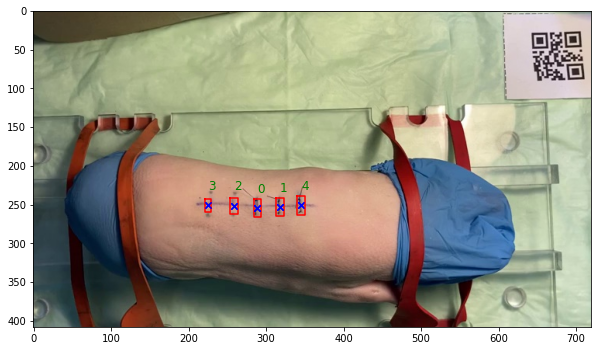

In [63]:
import skimage.io

plt.figure(figsize=(10, 10))

# image_fn = outputdir / "frame_000001.png"
image_fn = outputdir / "__cropped.mp4.jpg"
img = skimage.io.imread(image_fn)
plt.imshow(img)

# bboxes_stitches_global_centroid
bboxes_stitches_global_centroid = np.array([
    [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]
    for bbox in bboxes_stitches_global
])

for i, bbox in enumerate(bboxes_stitches_global):
    plt.plot([bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]], [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]], "r")
    plt.plot(bboxes_stitches_global_centroid[:, 0], bboxes_stitches_global_centroid[:, 1], "bx")
    # show stitch number in image
    plt.text(bboxes_stitches_global_centroid[i, 0] , bboxes_stitches_global_centroid[i, 1] - 20, str(i), fontsize=12, color="g")
    # plt.text(bboxes_stitches_global_centroid[:, 0], bboxes_stitches_global_centroid[:, 1], "ahoje")




(573, 2)
[     36.683      66.121      8.3156      26.971      93.576]
(489, 2)
[     73.942      103.05       46.28      20.703      130.45]


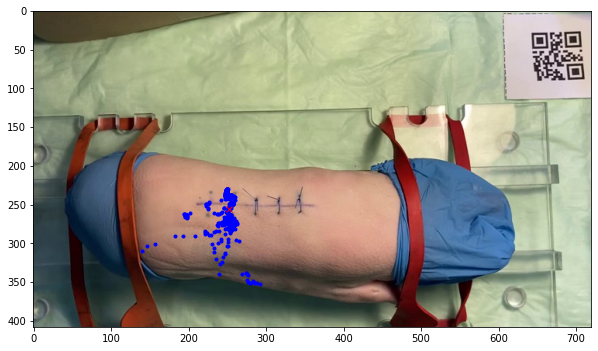

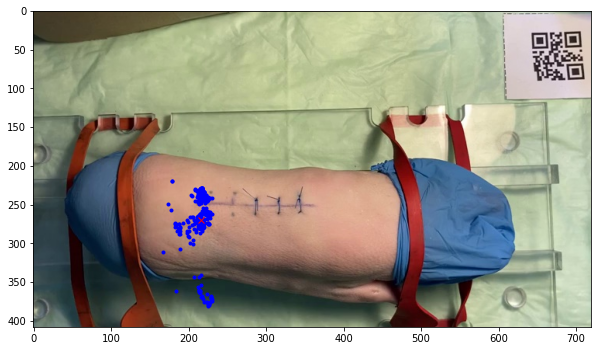

In [55]:

from typing import List
import numpy as np

stitch_split_frames = meta_json["stitch_split_frames"]

tracks_points_fn = outputdir / "tracks_points.json"

with open(tracks_points_fn, "r") as f:
    tracks_points = json.load(f)
    
tracks_points.keys()

tool_id = 0




def get_subsegment_of_tracks_points(tracks_points:dict, stitch_split_frames:List[int], stitch_id:int) -> dict:
    frame_ids = tracks_points["frame_ids"]
    data_pixels = tracks_points["data_pixels"]

    new_tracks_points = {
        "frame_ids": [None] * len(frame_ids),
        "data_pixels": [None] * len(data_pixels)
    }

    start_frame = stitch_split_frames[stitch_id]
    stop_frame = stitch_split_frames[stitch_id + 1]
    
    for tool_id in range(len(frame_ids)):
        new_tracks_points["frame_ids"][tool_id] = []
        new_tracks_points["data_pixels"][tool_id] = []
        
        
        for frame_id, data_px in zip(frame_ids[tool_id], data_pixels[tool_id]):
            if frame_id >= start_frame and frame_id <= stop_frame:
                new_tracks_points["frame_ids"][tool_id].append(frame_id)
                new_tracks_points["data_pixels"][tool_id].append(data_px)
                
            if frame_id > stop_frame:
                break
                
    return new_tracks_points

meta = {}
meta["stitch_static"] = {}

needle_holder_id = 1
for i in range(0, len(stitch_split_frames), 2):
    tracks_points_subsegment = get_subsegment_of_tracks_points(tracks_points, stitch_split_frames, i)
    
    needle_holder_points_px = np.asarray(tracks_points_subsegment["data_pixels"][needle_holder_id])
    print(needle_holder_points_px.shape)
    med = np.median(needle_holder_points_px, axis=0)
    
    
    
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.plot(needle_holder_points_px[:, 0], needle_holder_points_px[:, 1], "b.")
    plt.plot(med[0], med[1], "rx")
    
    
    
    # closest stitch bbox
    distances = np.linalg.norm(bboxes_stitches_global_centroid - med, axis=1)
    
    static_id = np.argmin(distances)
    
    stitch_label = stitch_json["stitch_labels"][static_id]
    stitch_id = static_id
    meta["stitch_static"][stitch_label] = {
        "static_id": stitch_id,
        "static_label": stitch_label,
        "static_bbox": bboxes_stitches_global[stitch_id]
    }
    
    
    
    
    
    
    
    
    


    

## Do whole processing together


2024-06-24 19:00:40.114 | DEBUG    | pigleg_cv:__init__:109 - ###############
2024-06-24 19:00:40.142 | DEBUG    | pigleg_cv:__init__:110 - device=cpu
2024-06-24 19:00:40.145 | DEBUG    | pigleg_cv:__init__:111 - test_first_seconds=False
2024-06-24 19:00:40.148 | DEBUG    | pigleg_cv:__init__:112 - is_microsurgery=False
2024-06-24 19:00:40.152 | DEBUG    | pigleg_cv:__init__:143 - self.is_microsurgery=False
2024-06-24 19:00:40.157 | INFO     | pigleg_cv:run:147 - CV processing started on ../piglegsurgeryweb/media/upload/20231213-082852_pigleg_test_4_c01bb28928f8241f5cb69c0cee9f09a0e873f815/pigleg_test_4.mp4, outputdir=del_test_video_output/pigleg_test_4.mp4
2024-06-24 19:00:40.160 | DEBUG    | pigleg_cv:run:150 - self.is_microsurgery=False
2024-06-24 19:00:40.163 | DEBUG    | pigleg_cv:run:151 - False, <class 'bool'>
2024-06-24 19:00:40.165 | DEBUG    | pigleg_cv:run:152 - <class 'bool'>
2024-06-24 19:00:40.165 | DEBUG    | pigleg_cv:run:153 - False
2024-06-24 19:00:40.167 | DEBUG    |

Fusing layers... 
IDetect.fuse


/opt/conda/lib/python3.8/site-packages/torch/functional.py:598: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2323.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-06-24 19:00:49.807 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:00:49.809 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:00:49.811 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[410, 287], [532, 286], [535, 164], [411, 164]], 'pix_size': 0.0002446659365537673, 'incision_bboxes': [[774.2468872070312, 706.2264404296875, 1064.2303466796875, 784.998291015625, 0.9780232310295105]], 'qr_size': 0.03, 'size_by_scene': 0.00015625, 'text'

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-06-24 19:00:56.260 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:291 - number of detected incisions = 1
2024-06-24 19:00:56.263 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:505 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[410, 287], [532, 286], [535, 164], [411, 164]], 'pix_size': 0.0002446659365537673, 'incision_bboxes': [[774.2468872070312, 706.2264404296875, 1064.2303466796875, 784.998291015625, 0.9780232310295105]], 'qr_size': 0.03, 'size_by_scene': 0.00015625, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00023340120243941213, 'bbox_scene_area': [237.48182678222656, 1.596093773841858, 1683.50341796875, 1080.0, 0.6937737464904785], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[404.9392395019531, 158.84629821777344, 542.061279296875, 293.9641418457031, 0.9962145686149597], [1111.7254638671875, 165.35377502441406, 1253.7729

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:04.055 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:04.057 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:04.060 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890246822574467, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 710.5921630859375, 534.5504760742188, 0.6441910266876221], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6380615234375, 80.8170166015625, 506.4442443847656, 154.3318328857422, 0.9947611689567566], [84.2149429321289, 78.57424926757812, 153.6857452392578, 145.8348

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:11.740 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:11.742 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:11.745 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.000489023987937676, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 709.862548828125, 534.6233520507812, 0.6477384567260742], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6281433105469, 80.8161392211914, 506.44061279296875, 154.3262481689453, 0.9947388768196106], [84.2376708984375, 78.5788803100586, 153.64669799804688, 145.89241

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:18.236 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:18.237 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:18.239 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890095066771629, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004424701757498524, 'bbox_scene_area': [0.0, 0.0, 704.8307495117188, 534.6377563476562, 0.6452385187149048], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6357116699219, 80.80646514892578, 506.40777587890625, 154.3137969970703, 0.994795024394989], [84.25965118408203, 78.60446166992188, 153.58633422851562, 145.8

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:26.239 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:26.240 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:26.242 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890170380090675, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00044251830957384576, 'bbox_scene_area': [0.0, 0.0, 711.1199951171875, 535.4285888671875, 0.6413721442222595], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6274719238281, 80.8107681274414, 506.4110107421875, 154.3135223388672, 0.9947785139083862], [84.17852020263672, 78.57734680175781, 153.56939697265625, 145.8

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:32.494 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:32.504 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:32.506 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004891435759369001, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004591000258371299, 'bbox_scene_area': [0.0, 0.0, 712.6258544921875, 535.1942749023438, 0.6450016498565674], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.0531005859375, 78.78205108642578, 153.3503875732422, 145.6607666015625, 0.9948126077651978], [437.62060546875, 80.84980773925781, 506.4107666015625, 154.29263

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:38.535 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:38.536 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:38.537 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.000489012318518458, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004446518750465642, 'bbox_scene_area': [0.0, 0.0, 693.3949584960938, 536.0, 0.6395825743675232], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6258239746094, 80.86217498779297, 506.4163818359375, 154.3540802001953, 0.9942029118537903], [84.17172241210938, 78.52228546142578, 153.58218383789062, 145.89688110351562

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:45.154 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:45.155 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:45.156 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004886776751473797, 'incision_bboxes': [[271.4137878417969, 352.6202697753906, 410.2554016113281, 391.03961181640625, 0.9781779050827026]], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004444566382094698, 'bbox_scene_area': [0.0, 0.0, 700.7938232421875, 535.907958984375, 0.6418917775154114], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6625061035156, 80.88617706298828, 506.4738464355469, 154.3650

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:51.673 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:51.674 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:51.675 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004876054523338215, 'incision_bboxes': [[270.26287841796875, 352.0305480957031, 410.5086975097656, 390.61376953125, 0.9813022017478943]], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00046039570111101955, 'bbox_scene_area': [0.0, 0.0, 720.0, 536.0, 0.6495135426521301], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.00880432128906, 79.19088745117188, 152.8837432861328, 146.4113006591797, 0.99504709243

Fusing layers... 
IDetect.fuse


2024-06-24 19:01:58.074 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-06-24 19:01:58.075 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-06-24 19:01:58.079 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004876054523338215, 'incision_bboxes': [[270.26287841796875, 352.0305480957031, 410.5086975097656, 390.61376953125, 0.9813022017478943]], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00046039570111101955, 'bbox_scene_area': [0.0, 0.0, 720.0, 536.0, 0.6495135426521301], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.00880432128906, 79.19088745117188, 152.8837432861328, 146.4113006591797, 0.99504709243

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-06-24 19:02:05.694 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:291 - number of detected incisions = 1
2024-06-24 19:02:05.698 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:291 - number of detected incisions = 1
2024-06-24 19:02:05.701 | DEBUG    | run_perpendicular:main_perpendicular:347 - len(imgs)=1
2024-06-24 19:02:05.754 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/pigleg_test_4.mp4/perpendicular_0.json'
2024-06-24 19:02:05.760 | DEBUG    | tools:save_json:26 - old keys: ['intersections', 'alphas']
2024-06-24 19:02:05.762 | DEBUG    | tools:save_json:28 - updated keys: ['intersections', 'alphas']
2024-06-24 19:02:06.147 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:53 - cfg_path=PosixPath('stitch_detection_mmdet_config.py'), True
2024-06-24 19:02:06.151 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:54 - checkpoint_path=PosixPath('/webapps/piglegsurgery/piglegcv/resources/stitch_detection_mode

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/stitch_detection_models/model.pth


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2024-06-24 19:02:11.992 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/pigleg_test_4.mp4/stitch_detection_0.json'
2024-06-24 19:02:12.006 | DEBUG    | tools:save_json:26 - old keys: ['stitch_labels', 'stitch_bboxes']
2024-06-24 19:02:12.009 | DEBUG    | tools:save_json:28 - updated keys: ['stitch_labels', 'stitch_bboxes']
2024-06-24 19:02:12.021 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:114 - number of filtered stitches = 4
2024-06-24 19:02:12.024 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:115 - Stitch detection finished, boxes in: del_test_video_output/pigleg_test_4.mp4/stitch_detection_0.json
2024-06-24 19:02:12.160 | DEBUG    | stitch_detection_mmdet:run_stitch_analyser:193 - R-squared 

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2024-06-24 19:03:15,390 - mmtrack - INFO - initialize CSPDarknet with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2024-06-24 19:03:15,569 - mmtrack - INFO - initialize YOLOXPAFPN with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2024-06-24 19:03:15,690 - mmtrack - INFO - initialize YOLOXHead with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}


load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack_hands_tools/epoch.pth


2024-06-24 19:03:20.433 | DEBUG    | pigleg_cv:run_video_processing:364 - Tracker finished in 68.07805585861206s.
2024-06-24 19:03:20.435 | DEBUG    | pigleg_cv:run_video_processing:367 - filename=del_test_video_output/pigleg_test_4.mp4/__cropped.mp4, outputdir=del_test_video_output/pigleg_test_4.mp4
2024-06-24 19:03:20.437 | DEBUG    | pigleg_cv:run_video_processing:368 - filename=True, outputdir=True
2024-06-24 19:03:20.442 | DEBUG    | run_report:convert_track_bboxes_to_center_points:771 - Sort data N=95
2024-06-24 19:03:20.443 | DEBUG    | run_report:convert_track_bboxes_to_center_points:772 - data_pixels=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
2024-06-24 19:03:20.448 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/pigleg_test_4.mp4/tracks_points.json'
2024-06-24 19:03:20.450 | DEBUG    | tools:save_json:28 - updated keys: ['frame_ids', 'data_pixels']
2024-06-24 19:03:20.456 | DEBUG    | pigleg_cv:prepare_operation_area_bbox:297 - len(points_pe

The model and loaded state dict do not match exactly

size mismatch for detector.bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for detector.bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for detector.bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for detector.bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for detector.bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([5, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mism

2024-06-24 19:03:21.041 | DEBUG    | pigleg_cv:run_video_processing:392 - self.meta['stitch_split_frames']=[0, 67]
2024-06-24 19:03:21.042 | DEBUG    | pigleg_cv:run_video_processing:393 - Stitch ends found in 0.5729560852050781s.
2024-06-24 19:03:21.054 | DEBUG    | run_report:__init__:959 - filename=PosixPath('del_test_video_output/pigleg_test_4.mp4/__cropped.mp4'), self.fps=15, self.size_input_video=[720, 536] 
2024-06-24 19:03:21.064 | DEBUG    | run_report:run:1015 - is_microsurgery=False, cut_frames=[0, 67]
2024-06-24 19:03:21.074 | DEBUG    | run_report:run:1083 - ruler_size_in_units=5, visualization_length_unit='cm'
2024-06-24 19:03:21.075 | DEBUG    | run_report:run:1117 - self.pix_size_m=0.0004575163398692811, output_video_resize_factor=0.7835820895522388, ruler_size_in_units=5, visualization_length_unit='cm'
2024-06-24 19:03:21.076 | DEBUG    | tools:__init__:449 - pixelsize=0.058387799564270156, ruler_size=5, unit='cm'
2024-06-24 19:03:21.079 | DEBUG    | run_report:run:112

bbox
[200.1399688720703, 332.7389373779297, 480.63160705566406, 409.90538024902344, 0.9813022017478943]


2024-06-24 19:03:26.644 | DEBUG    | run_report:go_over_tools_and_split_video_by_stitches:1420 - per stitch analysis object_full_name='Needle holder stitch 0' frame_idx_start=0 frame_idx_stop=57
2024-06-24 19:03:26.646 | DEBUG    | run_report:create_pdf_report_for_one_tool:336 - object_name='Needle holder'
2024-06-24 19:03:26.648 | DEBUG    | run_report:create_pdf_report_for_one_tool:337 - tool: T=3.8 , source_fps=15, len(frame_ids)=57
2024-06-24 19:03:26.650 | DEBUG    | run_report:create_pdf_report_for_one_tool:338 - whole vieo part: 4.333333333333333 sec, t[0]=0.0, t[-1]=4.333333333333333
2024-06-24 19:03:26.837 | DEBUG    | run_report:create_pdf_report_for_one_tool:397 - main_report: figures del_test_video_output/pigleg_test_4.mp4/graph_0c_needle_holder_trajectory_stitch_0.jpg is saved
2024-06-24 19:03:27.000 | DEBUG    | run_report:create_pdf_report_for_one_tool:426 - main_report: figures del_test_video_output/pigleg_test_4.mp4/fig_0a_needle_holder_graph_stitch_0.jpg is saved
2024

bbox
[200.1399688720703, 332.7389373779297, 480.63160705566406, 409.90538024902344, 0.9813022017478943]


2024-06-24 19:03:27.410 | DEBUG    | run_report:create_pdf_report_for_one_tool:397 - main_report: figures del_test_video_output/pigleg_test_4.mp4/graph_1c_forceps_trajectory_all.jpg is saved
2024-06-24 19:03:27.584 | DEBUG    | run_report:create_pdf_report_for_one_tool:426 - main_report: figures del_test_video_output/pigleg_test_4.mp4/fig_1a_forceps_graph_all.jpg is saved
2024-06-24 19:03:27.609 | DEBUG    | run_report:make_stats_and_images_for_one_tool_in_one_video_part:1503 - video_duration_s=4.466666666666667
2024-06-24 19:03:27.612 | DEBUG    | run_report:make_stats_and_images_for_one_tool_in_one_video_part:1504 - T=3.3333333333333335, L=0.11648689552203097, V=0.023549545405433983, unit='m'
2024-06-24 19:03:27.614 | DEBUG    | run_report:make_stats_and_images_for_one_tool_in_one_video_part:1505 - type(T)=<class 'float'>, type(L)=<class 'numpy.float64'>, type(V)=<class 'numpy.float64'>, type(unit)=<class 'str'>
2024-06-24 19:03:27.617 | DEBUG    | run_report:create_heatmap_report_pl

main_report: Video file del_test_video_output/pigleg_test_4.mp4/__cropped.mp4 is processed!


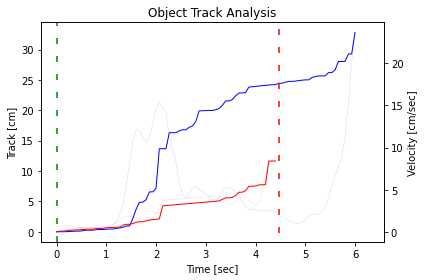

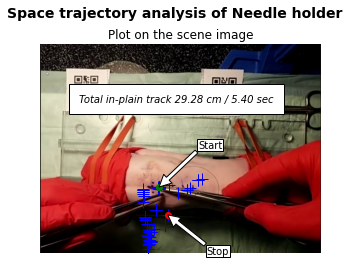

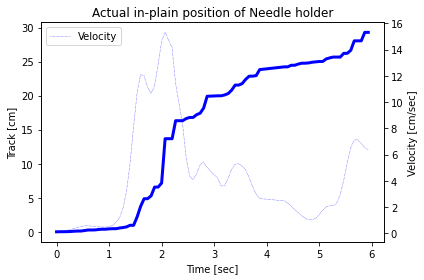

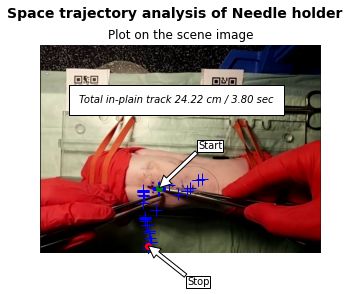

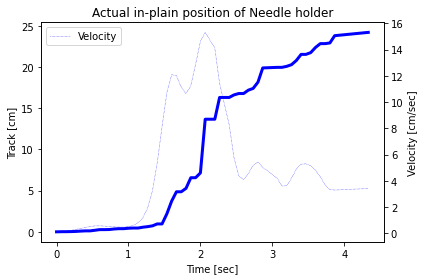

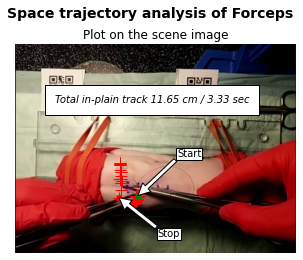

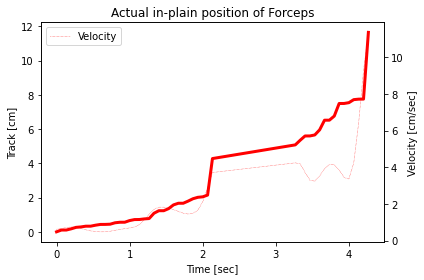

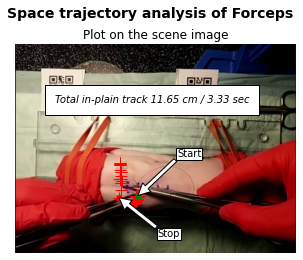

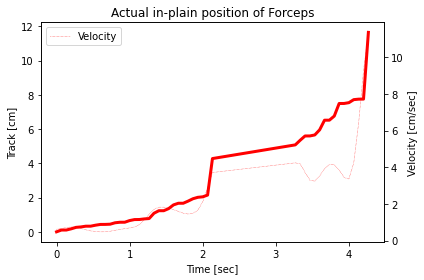

In [15]:
dcv = pigleg_cv.DoComputerVision(
    mediafile_path,
    outputdir,
    test_first_seconds=test_first_seconds,
    is_microsurgery=is_microsurgery,
    force_tracker=force_tracker
)
dcv.run()

In [16]:
logger

<loguru.logger handlers=[]>

In [17]:
from loguru import logger
logger.debug("ahoj")

In [18]:
logger.warning("asdf")

In [19]:
# report_data = dcv.make_report()